## Processing Cobalt Samples (Voltammetry)

Revised 26-Mar-2024 <br>
Written by Annaliese Meyer <br>
Massachusetts Institute of Technology <br>
Woods Hole Oceanographic Institution <br>

This notebook will allow you to convert raw .oew files from the NOVA2 software into peak heights, and from there to concentration values using the standard additions performed. This code assumes there are 3 measurement without additions, then additions to a concentration of 25 pM, 50 pM, 75 pM and 100 pM. This notebook corrects for volume considersations assuming an volume of 8.5 mL sample delivered into an overall reaction volume of 10 mL. It does *not* correct for blanks - this must be done manually, averaging blank values for each batch. 

This will potentially not return correct values for blanks, as the peaks may be too small to be picked up correctly. I advise checking blanks manually with the troubleshooting option at the bottom of the page to see where peaks are placed if a value comes back weirdly - it may have defaulted to selecting the Ni peak. This program will also return the R2 value for the standard curve, its slope, and the standard deviation of the Co concentration as derived from the three scans with no Co addition. Both the Co concentration from the average of the 'zero' scans and from the x-intercept of the standard curve are reported.

Please note that if a peak cannot be identified for one of the amperage scans for a given sample, then the concentration for that value will be returned as #N/A. This doesn't mean that the sample cannot be used - simply go into the amperage file, and either determine the concentration value by excluding the scan in question and using the Excel LINEST function, or using the troubleshooting script at the bottom of this program to adjust the parameters until the code can correctly identify the peak. You can also use ECDSOFT to find this peak and input the value in the amperage file. 



### This code will only function correctly if your files remain in the correct processing order associated with their timestamps; i.e. the 'date created' attribute must be the same as it was when exported from NOVA2. 

##### First, follow these steps
Launch within CoProcessing.yml environment

Make new directory within Station folder

Find your directory of interest and copy its path

In [1]:
#import all necessary packages

import numpy as np
import pandas as pd
import rampy as rp
import scipy
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn import preprocessing
from findpeaks import findpeaks
import plotly.graph_objects as go
import os
import csv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

In [378]:
directory = input("Choose your directory:\n") #copy the entire path for your directory of interest





Choose your directory:
/Users/annaliesemeyer/Documents/Cobalt Computer Backup/Co Raw Data ACSM/GP17-OCE/Blanks Run Separately/2-Feb-2023


In [379]:
#run this to intialize the function

def co_raw(directory):   
    
    filehome = os.listdir(directory)
    filehome.sort(key=lambda x: os.stat(os.path.join(directory, x)).st_mtime) #reads in files according to their order in the directory 
    
    fieldnames = ['File', 'Amperage'] #assigns field names to columns from raw NOVA2 files (.oew files)
    with open(f'{directory} Amperage.csv','w') as writefile: #file will be named using the identified directory

    
        writer = csv.writer(writefile) #initilaize 'Amperage' file 
        
        writer.writerow(fieldnames)
    
        for filename in filehome:
            
            print(filename)
            f = os.path.join(directory, filename)
            spectrum = pd.read_csv(f, delimiter = '\t')
    

            #Rename columns to usable
            spectrum.rename(columns = {'Potential applied (V)':'V', 'WE(1).Current (A)':'I'}, inplace = True) #change variable names for ease of programming

            spectrum = spectrum.to_numpy()
            spectrum = rp.flipsp(spectrum) #flip x axis for interpolation algorithm

            x1 = np.array(spectrum[:,0]) #assign columns to x and y
            y1 = np.array(spectrum[:,1])
            a = np.where(x1<0)
            acount = (np.array(a)).size
            x = x1[a]
            y = y1[a]
            

            y_smo_4 = rp.smooth(x,y,method="savgol",window_length=7,polyorder=5) #smooth function using 'savgol' algorithm


            # need to define some fitting regions for the spline that exclude peaks
            roi = np.array([[-1.4,-1.05],[-0.94,-0.6]])
    
            # calculating the baselines 

            ycalc_poly_smooth, base_poly_smooth = rp.baseline(x, y, roi, 'poly', polynomial_order=9) #baseline calculated


            base_poly_reshape_smooth = base_poly_smooth.reshape(acount,)
 

            y_corr_smooth = np.subtract(y_smo_4, base_poly_reshape_smooth) #baseline subtracted from smoothed data - baseline subtraction is just to amplify the peaks to allow the program to identify them. Concentration/peak height is determined from true data.

            indices = find_peaks(-y_corr_smooth, distance = 8, height = 5e-9)[0] #identify min peaks (troughs), give threshold height and distance between peaks - can be adjusted as needed
    

            indices2 = find_peaks(y_corr_smooth, distance = 15)[0] #identify maxima - this gives you the edges of the minima to place the flat baseline 
            
            indicesnick = np.array((indices[x[indices]>-1.03])) #get all the peaks greater than a value to id the nickel peak - helps place where the Co peak will be
            
            #'try' block: lets you skip erroneous scans
            try:
                nickelpeak = min(y_corr_smooth[indicesnick]) 
            

                nickelindex = np.where(y_corr_smooth[indices]==nickelpeak)

                coindexstart = (np.array(nickelindex)-1)
                coindex = coindexstart.flatten()
        

                lowerbound = max(x[indices2[x[indices2]<x[indices[coindex]]]])
                upperbound = min(x[indices2[x[indices2]>x[indices[coindex]]]])

                xindlow = np.where(x[indices2]==lowerbound) #identify index of threshold list where the lowerbound is located
                indexlow = indices2[xindlow] #use that index to find the corresponding index value in the greater index list of all x values

                xindhigh = np.where(x[indices2]==upperbound) #as above, for upperbound
                indexhigh = indices2[xindhigh]

                cobaselinex = np.concatenate((x[indices2[xindlow]], x[indices2[xindhigh]]), axis = 0) #flat peak baseline coordinates x
                cobaseliney = np.concatenate((y[indices2[xindlow]], y[indices2[xindhigh]]), axis = 0) #as above, y


                peakx = x[indices[coindex]]
                peaky = y[indices[coindex]]

                p1 = np.array((cobaselinex[0],cobaseliney[0]))
                p2 = np.array((cobaselinex[1],cobaseliney[1]))
                p3 = np.array((peakx[0],peaky[0]))
    
                d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1) #calculate peak height from identified baseline (method 1, not vertical, unused)
        
                points = [p1,p2] #calculate peak height, method 2 
                x_coords, y_coords = zip(*points)
                A = np.vstack([x_coords,np.ones(len(x_coords))]).T
                m, c = np.linalg.lstsq(A, y_coords)[0] 

                hline = m*(peakx[0])+c

                height = abs(peaky[0]-hline) #return height of peak
            
                data = [filename, height]
          
                writer.writerow(data)
            
            except:
                
                data = [filename, '#N/A'] #if peak cannot be identified, return #N/A and keep going
                
                writer.writerow(data)
                
    
    

    
    
        

    
        
        

In [380]:
co_raw(directory) #run the above function
    

Blank 2-Feb-2023(3).oew
Blank 2-Feb-2023(4).oew
Blank 2-Feb-2023(5).oew
Blank 2-Feb-2023(6).oew
Blank 2-Feb-2023(7).oew
Blank 2-Feb-2023(8).oew
Blank 2-Feb-2023(9).oew
Blank 2-Feb-2023(10).oew
Blank 2-Feb-2023(11).oew
Blank 2-Feb-2023(12).oew
Blank 2-Feb-2023(13).oew
Blank 2-Feb-2023(14).oew
Blank 2-Feb-2023(15).oew
Blank 2-Feb-2023(16).oew
Blank 2-Feb-2023(17).oew
Blank 2-Feb-2023(18).oew
Blank 2-Feb-2023(19).oew
Blank 2-Feb-2023(20).oew
Blank 2-Feb-2023(21).oew
Blank 2-Feb-2023(22).oew
Blank 2-Feb-2023(23).oew


In [381]:
#initialize function to convert amperage to concentration

def amps_to_conc(directory):

    amperage = pd.read_csv(f'{directory} Amperage.csv') #pulls file from first step

    fieldnames = ['File', 'Averaged Concentration','x Intercept','R_squared','Standard Deviation','Slope'] #name columns
    with open(f'{directory} Concentrations.csv','w') as writefile: #file will be named using the identified directory

        writer = csv.writer(writefile)
        
        writer.writerow(fieldnames)

        for i in range(len(amperage)):
    
            if amperage.index[i]%7==0: #groups values into multipes of 7s 
            
                try: 
                    conc = amperage[i:i+7]
                    conc.insert(2, 'Addition', [0,0,0,25,50,75,100]) #match amperage to standard curve
                    x = np.array(conc['Addition']).reshape(-1,1)
                    y = np.array(conc['Amperage'])
                    lm = LinearRegression()
                    model = lm.fit(x, y) #calculate line
                    xint = -((-model.intercept_)/model.coef_)/0.85 #calulate concentration from account for dilution
                    mean = np.mean(conc['Amperage'][0:3]) #calculate average from 'zero' scans and slope of standard curve
                    actual = (mean/model.coef_)/0.85 #account for dilution
                    p1 = (conc['Amperage'][i]/model.coef_)/0.85 #calculate individual concentrations per scan for standard deviation
                    p2 = (conc['Amperage'][i+1]/model.coef_)/0.85
                    p3 = (conc['Amperage'][i+2]/model.coef_)/0.85
                    std = np.std([p1,p2,p3])
                    r_sq = model.score(x, y) #get R2 of slope
                    data = [amperage['File'][i],actual,xint,r_sq,std,model.coef_] #write data to file
                    writer.writerow(data)
                    print(amperage['File'][i]) #this will print out the file name for each sample to show that it has been calculated
                    plt.plot(x,y) #this prints out the plot for each file as a brief visual check on the linearity of the slopes. 
                    
                except: 
                    data = [amperage['File'][i], '#N/A'] #if calculation cannot be completed, move onto the next group
                    print(amperage['File'][i],'needs correction') #this will identify if the concentration for a given sample cannot be calculated, ie is missing an amperage measurement. See troubleshooting notes at top. 
                    writer.writerow(data)
                
        writefile.close()

Blank 2-Feb-2023(3).oew
Blank 2-Feb-2023(10).oew
Blank 2-Feb-2023(17).oew


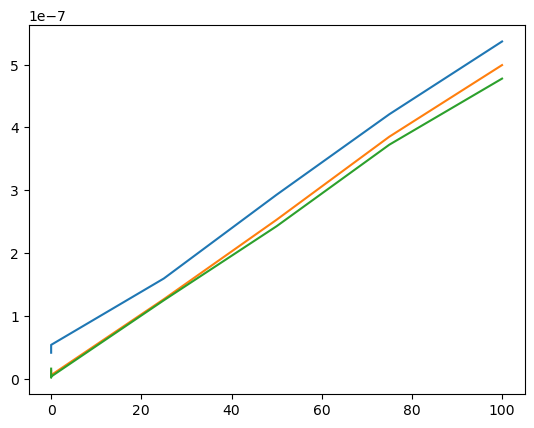

In [382]:
amps_to_conc(directory) #this will run the 'amperage' file associated with this directory and return concentrations. These concentrations have not been blank corrected. 


## Did something break, or come back with a low R2 value? Troubleshoot here.

You can use this area to go through scan by scan and inspect the peaks identified, pull out the correct amperage values, or determine that a scan needs to be dropped from your calculations. 

In [419]:
file = input("Choose the file that's giving you trouble:\n") #full path for the sample file in question, eg /Users/person/Documents/Co Raw Data/GP17-OCE/Runs/23-Mar-2023/23-Mar-2023(109).oew








Choose the file that's giving you trouble:
/Users/annaliesemeyer/Documents/Cobalt Computer Backup/Co Raw Data ACSM/GP17-OCE/Runs/23-Mar-2023/23-Mar-2023(109).oew


2.6584472656249954e-07

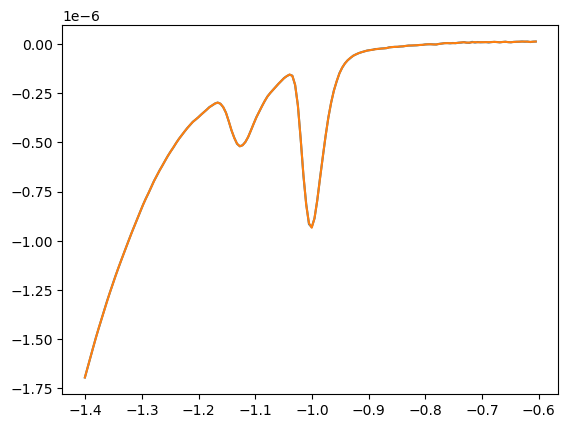

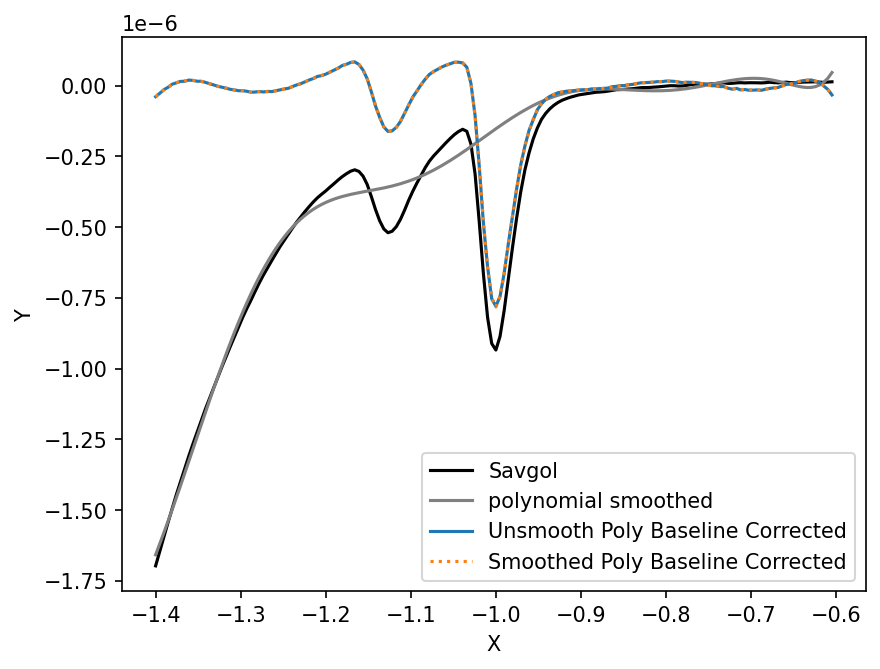

In [423]:
spectrum = pd.read_csv(file, delimiter = '\t')


#Rename columns to usable
spectrum.rename(columns = {'Potential applied (V)':'V', 'WE(1).Current (A)':'I'}, inplace = True)

spectrum = spectrum.to_numpy()
spectrum = rp.flipsp(spectrum) #flip x axis for interpolation algorithm




x1 = np.array(spectrum[:,0])

y1 = np.array(spectrum[:,1])
a = np.where(x1<0)
acount = (np.array(a)).size
x = x1[a]
y = y1[a]

y_smo_4 = rp.smooth(x,y,method="savgol",window_length=7,polyorder=5)



# need to define some fitting regions for the spline - this is the best thing to modify to try to get it to pick the right peak if the program is trying to read a value from somewhere else.
roi = np.array([[-1.4,-1.03],[-0.94,-0.6]]) #want to exclude the regions where the peaks are

# calculating the baselines

ycalc_poly_smooth, base_poly_smooth = rp.baseline(x, y, roi, 'poly', polynomial_order=9) #baseline calculated
ycalc_poly, base_poly = rp.baseline(x, y, roi, 'poly', polynomial_order=9)

# doing the figure to plot intial data, smoothed data, and visualize what the baseline subtraction looks like. 
plt.figure(dpi=150)
plt.plot(x, y_smo_4, "k-", label="Savgol")
plt.plot(x, y, label = 'Raw')
plt.plot(x, base_poly_smooth, "-", color="grey", label="Calculated Poly Baseline")

plt.xlabel("X")
plt.ylabel("Y")


base_poly_reshape = base_poly.reshape(acount,)
base_poly_reshape_smooth = base_poly_smooth.reshape(acount,)
y_smo_4 = y_smo_4.reshape(acount,)


y_corr_smooth = np.subtract(y_smo_4, base_poly_reshape_smooth) #baseline subtracted from smoothed data - baseline subtraction is just to help with peak id, subtracted data is not used for the calculation
y_corr = np.subtract(y, base_poly_reshape) #baseline subtracted from unsmoothed data


plt.plot(x,y_corr,'-', label= 'Unsmooth Poly Baseline Corrected')
plt.plot(x, y_corr_smooth,":", label = 'Smoothed Poly Baseline Corrected')

plt.legend()


indices = find_peaks(-y_corr_smooth, distance = 8, height = 5e-9)[0]

indices2 = find_peaks(y_corr_smooth, distance = 15)[0] #this can also be modified to help it identify the right peak


indicesnick = np.array((indices[x[indices]>-1.03])) #this can also be modified if the nickel peak has shifted and the program can't find it

nickelpeak = min(y_corr_smooth[indicesnick])

nickelindex = np.where(y_corr_smooth[indices]==nickelpeak) #find nickel peak and use it to locate Co peak

coindexstart = (np.array(nickelindex)-1)
coindex = coindexstart.flatten()


lowerbound = max(x[indices2[x[indices2]<x[indices[coindex]]]])
upperbound = min(x[indices2[x[indices2]>x[indices[coindex]]]])


xindlow = np.where(x[indices2]==lowerbound) #identify index of threshold list where the lowerbound is located
indexlow = indices2[xindlow] #use that index to find the corresponding index value in the greater index list of all x values

xindhigh = np.where(x[indices2]==upperbound) #as above, for upperbound
indexhigh = indices2[xindhigh]



cobaselinex = np.concatenate((x[indices2[xindlow]], x[indices2[xindhigh]]), axis = 0) #get coordinates for peak edges to be able to get flat baseline
cobaseliney = np.concatenate((y[indices2[xindlow]], y[indices2[xindhigh]]), axis = 0)


peakx = x[indices[coindex]]
peaky = y[indices[coindex]]


#Show scan and where the peak has been picked from

fig = go.Figure()

fig.add_trace(go.Scatter(x=x,
    y=y,
    mode='lines',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=[x[p] for p in indices],
    y=[y[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Desired Peaks'
))



fig.add_trace(go.Scatter(
    x=[x[p] for p in indices2],
    y=[y[j] for j in indices2],
    mode='markers',
    marker=dict(
        size=8,
        color='blue',
        symbol='cross'
    ),
    name='Detected Thresholds'


))

#black dot shows the actual peak selected for calculation
fig.add_trace(go.Scatter(x=cobaselinex, y=cobaseliney, mode = 'lines', line=dict(color="Black", width=1),name = 'Linear Baseline'))
fig.add_trace(go.Scatter(x = np.array(peakx), y = np.array(peaky), mode = 'markers', marker = dict(size = 7, color = 'black', symbol = 'circle'),name = 'Peak Point'))


fig.show()

#calculate the peak height, two methods as above - method 2 used
p1 = np.array((cobaselinex[0],cobaseliney[0]))
p2 = np.array((cobaselinex[1],cobaseliney[1]))

p3 = np.array((peakx[0],peaky[0]))
    
d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        
points = [p1,p2]
x_coords, y_coords = zip(*points)
A = np.vstack([x_coords,np.ones(len(x_coords))]).T
m, c = np.linalg.lstsq(A, y_coords)[0]

hline = m*(peakx[0])+c

height = abs(peaky[0]-hline)
            
height #print out identified peak height for this scan